# IT Job Classification:

In [1]:
import gensim
import os
import collections
import smart_open
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

RANDOM_STATE = 41

In [3]:
df = pd.read_csv('data job posts.csv')

In [4]:
df['text'] = df.jobpost.apply(gensim.utils.simple_preprocess)
df["label"] = df.IT
df = df[["text", "label"]]
df.head(5)

,text,label
0,"[ameria, investment, consulting, company, job,...",False
1,"[international, research, exchanges, board, ir...",False
2,"[caucasus, environmental, ngo, network, cenn, ...",False
3,"[manoff, group, job, title, bcc, specialist, p...",False
4,"[yerevan, brandy, company, job, title, softwar...",True


### Define a Function to Read and Preprocess Text

In [5]:
train, test = train_test_split(df, test_size=0.30, random_state=RANDOM_STATE, stratify=df["label"])

In [6]:
def read_corpus(dataframe, tokens_only=False):
    for i, row in enumerate(dataframe.iterrows()):
        if tokens_only:
            yield row[1]['text']
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(row[1]['text'], [row[1]['label']])

In [7]:
train_corpus = list(read_corpus(train))
test_corpus = list(read_corpus(test, tokens_only=True))

In [8]:
train_corpus[:3]

[TaggedDocument(words=['save', 'the', 'children', 'international', 'armenian', 'representative', 'office', 'title', 'driver', 'logistician', 'term', 'full', 'time', 'start', 'date', 'time', 'march', 'location', 'yerevan', 'armenia', 'job', 'description', 'the', 'driver', 'logistician', 'will', 'be', 'fully', 'responsible', 'for', 'the', 'maintenance', 'and', 'technical', 'oversight', 'of', 'the', 'representative', 'office', 'vehicle', 'fleet', 'transport', 'operations', 'and', 'reporting', 'this', 'includes', 'scheduling', 'of', 'vehicles', 'for', 'servicing', 'management', 'of', 'vehicle', 'fleet', 'and', 'coordination', 'of', 'vehicle', 'assignments', 'for', 'staff', 'transportation', 'and', 'supervision', 'of', 'drivers', 'the', 'incumbent', 'will', 'be', 'ultimately', 'responsible', 'for', 'ensuring', 'that', 'all', 'sci', 'personnel', 'and', 'property', 'are', 'transported', 'in', 'the', 'safest', 'manner', 'possible', 'and', 'in', 'strict', 'accordance', 'with', 'relevant', 'agen

In [9]:
len(test_corpus[:1][0])

249

### Training the Model

**Instantiate a Doc2Vec Object**

In [10]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

### Build a Vocabulary

In [11]:
model.build_vocab(train_corpus)

**Time to Train**

In [12]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

Wall time: 5min 12s


## Assessing Mode

In [13]:
doc_id = 0
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
inferred_vector = model.infer_vector(train_corpus[doc_id].words)
print("Inferred Vector: {}".format(inferred_vector))
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Document (0): «save the children international armenian representative office title driver logistician term full time start date time march location yerevan armenia job description the driver logistician will be fully responsible for the maintenance and technical oversight of the representative office vehicle fleet transport operations and reporting this includes scheduling of vehicles for servicing management of vehicle fleet and coordination of vehicle assignments for staff transportation and supervision of drivers the incumbent will be ultimately responsible for ensuring that all sci personnel and property are transported in the safest manner possible and in strict accordance with relevant agency and donor policy and procedures and local traffic regulations the driver logistician will also be responsible for outsourcing services for office maintenance and repair transportation services for delivery of materials to the projects sites and logistical support to the sci staff job overse

## Testing the Model

In [14]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_corpus) - 1)
inferred_vector = model.infer_vector(test_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Test Document (3902): «melicka gm ltd title sales representative location yerevan armenia job description job represent the company interests and develop its business negotiate contracts with potential customers collect orders handle those and organize the placement plan and organize shipments of orders control goods turnover on customers warehouses prepare accurate monthly report about the activities required qualifications university degree at least years of work experience in relevant field sales oriented personality good communication skills ability to take initiative and solve problems fluency in armenian and russian languages knowledge of english language is plus excellent organizational and planning skills computer literacy existence of own car application procedures please apply to this job by sending your cover letter and resume to toptex please clearly mention in your application letter that you learned of this job opportunity through career center and mention the url of its 

### Use Doc2Vec with SVM

In [15]:
train_X, train_y = [], []
for corpora in train_corpus:
    train_X.append(model.infer_vector(corpora.words))
    train_y.append(corpora.tags[0])
    
train_X = np.array(train_X)
train_y = np.array(train_y)

In [16]:
test_X = []
for corpora in test_corpus:
    test_X.append(model.infer_vector(corpora))
    
test_X = np.array(test_X)

In [17]:
test_y = test['label']

In [18]:
from sklearn import svm

clf = svm.SVC(gamma=0.001, C=100.)

clf.fit(train_X, train_y)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

**Predicting Y for test**

In [19]:
predicted_y = clf.predict(test_X)

In [20]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report

def print_conf_matrix(y_true, y_pred, 
                             classes,
                             normalize=False,
                             title='Confusion matrix',
                             cmap=plt.cm.Blues):
    

    cm = confusion_matrix(y_true, y_pred)

    # Configure Confusion Matrix Plot Aesthetics (no text yet) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

    # Calculate normalized values (so all cells sum to 1) if desired
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) #(axis=1)[:, np.newaxis]

    # Place Numbers as Text on Confusion Matrix Plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

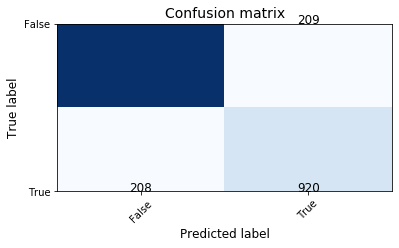

In [21]:
print_conf_matrix(y_true=test_y, y_pred=predicted_y, classes=["False", "True"])

In [22]:
rpt = classification_report(test_y, predicted_y)
print(rpt)

              precision    recall  f1-score   support

       False       0.95      0.95      0.95      4573
        True       0.81      0.82      0.82      1128

    accuracy                           0.93      5701
   macro avg       0.88      0.88      0.88      5701
weighted avg       0.93      0.93      0.93      5701

